In [1]:
import tensorflow as tf

/home/eblancoh/anaconda3/envs/universe/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Generamos un buen número de datos aleatorios de los que hacer uso para realizar la regresión:

In [3]:
# Elegimos el número de variables independientes
num_features = 1000000
# Generamos los valores de x 
x_data = np.linspace(0.0, 10.0, num_features)
# Y les metemos algo de ruido
x_data += np.random.uniform(-0.5,0.5,num_features)

In [4]:
x_data

array([-0.44754162,  0.15935687,  0.14371641, ..., 10.46588308,
        9.81817285,  9.56533623])

In [5]:
# Generamos las variables dependientes:
# y_label = m · x_data + b + ruido

# Elegimos m = 2.0 y b = 1.5

In [6]:
y_label = 2.0 * x_data + 1.5 + np.random.normal(-2, 2, num_features)

In [7]:
# Pandas nos permite oredenar en formato tabular todas nuestras variables para acceder de manera rápida a ellas
my_data = pd.concat([pd.DataFrame(data=x_data,columns=["x_data"]),
                     pd.DataFrame(data=y_label,columns=["y_label"])], 
                    axis = 1)

In [8]:
# Una breve muestra de cómo la variable "my_data" recoge las variables sobre las que se realizará la regresión
my_data.head()

,x_data,y_label
0,-0.447542,0.025977
1,0.159357,-0.426116
2,0.143716,1.978254
3,0.471293,3.191313
4,-0.038265,2.097492


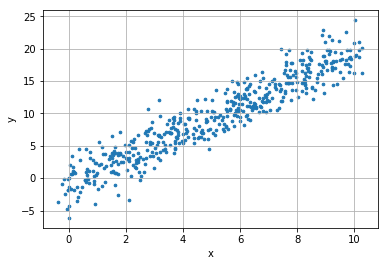

In [9]:
# Elegimos una muestra de 500 pares de datos para su representación. 
sampling = my_data.sample(n = 500)
plt.scatter(sampling["x_data"], sampling["y_label"], s = 7)
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Dado el elevado número de variables que estamos manejando, debemos partir nuestro dataset en batches de un determinado tamaño para entrenar nuestro modelo.
Elegiremos un tamaño de batch de 10 puntos al azar cada vez.

In [10]:
batch_size = 10

In [11]:
# Inicializamos con valores aleatorios como variables la pendiente y la intersección 
# de nuestra recta a ajustar a los datos.
misc = np.random.rand(2)

m = tf.Variable(misc[0], dtype = tf.float32)
b = tf.Variable(misc[1], dtype = tf.float32)

In [12]:
x = tf.placeholder(tf.float32,[batch_size])
y = tf.placeholder(tf.float32,[batch_size])

In [13]:
y_model = m * x + b

La función de pérdida que vamos a usar se puede construir fácilmente con TensorFlow:

In [14]:
# Elegimos como función de coste la RMS.
error = tf.reduce_sum(tf.square(y - y_model))

In [15]:
# Podemos escoger el optimizador que deseemos. En este caso recurrimos a tf.train.GradientDescentOptimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001)
train = optimizer.minimize(error)

In [16]:
init = tf.global_variables_initializer()

In [17]:
with tf.Session() as sess:
    
    sess.run(init)
    # Elegimos un número de batches 
    num_batches = 10000
    
    for i in range(num_batches):
        
        # Creamos conjuntos de índices aleatorios de tamaño batch_size para muestrear en el dataset
        rand_ind = np.random.randint(num_features, size = batch_size)
        
        # Pasamos las variables en un feed dictionary: sess.run(operation, feed_dict={...})
        # La operación es la dirigida a minimizar el error a través del optimizador elegido
        sess.run(train, feed_dict= {x: x_data[rand_ind], y:y_label[rand_ind]})
        
    # Los resultados de la pendiente y el punto de intersección    
    final_m, final_b = sess.run([m, b])

In [18]:
# Los valores estimados para la pendiente "m" y el punto de intersección "b" son respectivamente:
print (final_m, final_b)

2.0251372 -0.46674028


## Evaluación del ajuste

In [19]:
# Elegimos un conjunto de variables independientes de prueba y obtenemos su predicción 
x_test = np.linspace(-1, 12, 50)
y_test = final_m * x_test + final_b

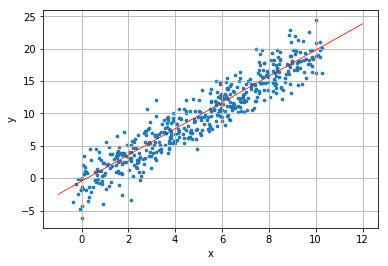

In [20]:
plt.scatter(sampling["x_data"], sampling["y_label"], s = 7)
plt.plot(x_test, y_test, 'r', linewidth = .75)
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

La línea roja estimada por nuestro modelo se ajusta adecuadamente a la nube de puntos. 
El coeficiente de determinación r-squared para nuestro ajuste a toda la nube de puntos:

In [21]:
# Suma de los cuadrados de los residuos:
SS_res = np.sum((y_label - (final_m * x_data + final_b))**2)
# La suma de los cuadrados totales se define como:
SS_tot = np.sum((y_label - np.mean(y_label))**2)

# El coeficiente r**2 se define como:
r_squared = 1 - SS_res/SS_tot

In [22]:
r_squared

0.8931486453016766

## tf.estimator API

En esta parte del notebook se proporciona una introducción al uso de los Estimadores en TensorFlow. Estos estimadores son
una API de TensorFlow que simplifican la programación de algortimos de Machine Learning. 
Los Estimadores encapsulan el entrenamiento, evaluación y predicción.
Además, son capaces de construir el grafo, inicializar variables, crear checkpoints del modelo y guardar summaries para TensorBoard.

In [23]:
feat_cols = [tf.feature_column.numeric_column("x", shape=[1])]

In [24]:
estimator = tf.estimator.LinearRegressor(feature_columns = feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6c7fa39eb8>, '_global_id_in_cluster': 0, '_task_id': 0, '_is_chief': True, '_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_service': None, '_keep_checkpoint_every_n_hours': 10000, '_task_type': 'worker', '_log_step_count_steps': 100, '_session_config': None, '_num_ps_replicas': 0, '_model_dir': '/tmp/tmprht7bymv', '_evaluation_master': '', '_save_checkpoints_secs': 600, '_num_worker_replicas': 1}


### Partición del dataset en conjuntos de entrenamiento y evaluación

In [25]:
# Hacemos uso de la función train_test_split de sklearn
from sklearn.model_selection import train_test_split

In [26]:
x_train, x_eval, y_train, y_eval = train_test_split(x_data, y_label, test_size=0.25)

In [27]:
print(x_train.shape, y_train.shape)
print(x_eval.shape, y_eval.shape)

(750000,) (750000,)
(250000,) (250000,)


### Generación de los inputs con los que alimentaremos al estimador

In [28]:
input_func = tf.estimator.inputs.numpy_input_fn({"x": x_train}, y_train, batch_size=10, num_epochs=None, shuffle=True)

In [29]:
train_input_func = tf.estimator.inputs.numpy_input_fn({"x": x_train}, y_train, batch_size=10, num_epochs=10000, shuffle=False)

In [30]:
eval_input_func = tf.estimator.inputs.numpy_input_fn({"x": x_eval}, y_eval, batch_size=10, num_epochs=10000, shuffle=False)

### Entrenamiento del estimador

In [31]:
estimator.train(input_fn = input_func, steps = 100000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmprht7bymv/model.ckpt.
INFO:tensorflow:loss = 1561.4055, step = 1
INFO:tensorflow:global_step/sec: 295.879
INFO:tensorflow:loss = 33.30817, step = 101 (0.341 sec)
INFO:tensorflow:global_step/sec: 320.604
INFO:tensorflow:loss = 82.274284, step = 201 (0.315 sec)
INFO:tensorflow:global_step/sec: 439.769
INFO:tensorflow:loss = 26.18623, step = 301 (0.224 sec)
INFO:tensorflow:global_step/sec: 378.781
INFO:tensorflow:loss = 85.68568, step = 401 (0.263 sec)
INFO:tensorflow:global_step/sec: 366.102
INFO:tensorflow:loss = 22.66417, step = 501 (0.275 sec)
INFO:tensorflow:global_step/sec: 339.75
INFO:tensorflow:loss = 25.106071, step = 601 (0.293 sec)
INFO:tensorflow:global_step/sec: 270.008
INFO:tensorflow:loss 

In [32]:
train_metrics = estimator.evaluate(input_fn = train_input_func, steps = 10000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-04-09:34:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmprht7bymv/model.ckpt-100000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1000/10000]
INFO:tensorflow:Evaluation [2000/10000]
INFO:tensorflow:Evaluation [3000/10000]
INFO:tensorflow:Evaluation [4000/10000]
INFO:tensorflow:Evaluation [5000/10000]
INFO:tensorflow:Evaluation [6000/10000]
INFO:tensorflow:Evaluation [7000/10000]
INFO:tensorflow:Evaluation [8000/10000]
INFO:tensorflow:Evaluation [9000/10000]
INFO:tensorflow:Evaluation [10000/10000]
INFO:tensorflow:Finished evaluation at 2018-05-04-09:34:24
INFO:tensorflow:Saving dict for global step 100000: average_loss = 3.9875007, global_step = 100000, loss = 39.875008


In [33]:
eval_metrics = estimator.evaluate(input_fn = eval_input_func, steps = 10000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-04-09:34:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmprht7bymv/model.ckpt-100000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1000/10000]
INFO:tensorflow:Evaluation [2000/10000]
INFO:tensorflow:Evaluation [3000/10000]
INFO:tensorflow:Evaluation [4000/10000]
INFO:tensorflow:Evaluation [5000/10000]
INFO:tensorflow:Evaluation [6000/10000]
INFO:tensorflow:Evaluation [7000/10000]
INFO:tensorflow:Evaluation [8000/10000]
INFO:tensorflow:Evaluation [9000/10000]
INFO:tensorflow:Evaluation [10000/10000]
INFO:tensorflow:Finished evaluation at 2018-05-04-09:34:36
INFO:tensorflow:Saving dict for global step 100000: average_loss = 3.99437, global_step = 100000, loss = 39.9437


In [34]:
# Las estadísticas del entrenamiento y de la evaluación de nuestro test dataset son:
print("train metrics: {}".format(train_metrics))
print("eval metrics: {}".format(eval_metrics))

train metrics: {'average_loss': 3.9875007, 'loss': 39.875008, 'global_step': 100000}
eval metrics: {'average_loss': 3.99437, 'loss': 39.9437, 'global_step': 100000}


### Obteniendo las predicciones del modelo

In [35]:
# Volvemos a hacer uso de tf.estimator.inputs.numpy_input_fn()
# Intentamos predecir qué valores obtendríamos del modelo si introducimos, 
# por ejemplo, un vector np.linspace(0,10,10)
input_fn_predict = tf.estimator.inputs.numpy_input_fn({"x": np.linspace(0,10,10)}, shuffle=False)

In [36]:
list(estimator.predict(input_fn = input_fn_predict))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmprht7bymv/model.ckpt-100000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'predictions': array([-0.49040818], dtype=float32)},
 {'predictions': array([1.738045], dtype=float32)},
 {'predictions': array([3.9664981], dtype=float32)},
 {'predictions': array([6.194951], dtype=float32)},
 {'predictions': array([8.423405], dtype=float32)},
 {'predictions': array([10.651857], dtype=float32)},
 {'predictions': array([12.880311], dtype=float32)},
 {'predictions': array([15.108764], dtype=float32)},
 {'predictions': array([17.337217], dtype=float32)},
 {'predictions': array([19.56567], dtype=float32)}]

In [37]:
# Para mejor manejabilidad a la hora de realizar cálculs, hacemos un append de las predicciones:
predictions = []
for x in estimator.predict(input_fn = input_fn_predict):
    predictions.append(x['predictions'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmprht7bymv/model.ckpt-100000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


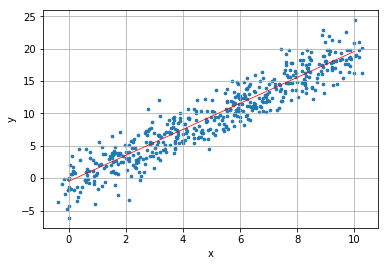

In [38]:
# Volvemos a representar una muestra de nuestros datos para superponer las predicciones anteriormente calculadas.
plt.scatter(sampling["x_data"], sampling["y_label"], s = 7)
plt.plot(np.linspace(0,10,10), predictions, 'r', linewidth = .75)
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Con esto hemos conseguido abordar un problema de regresión haciendo uso de TensorFlow de manera satisfactoria.